In [ ]:
from Models.SCILD_main import *
from Models.Help_func import create_LRDatabase_D
import scanpy as sc
import squidpy as sq
import warnings
from scipy.sparse import csr_matrix
warnings.filterwarnings('ignore')
np.random.seed(42)

# import data

In [2]:
adata = sc.read_h5ad('./Example_data/PDAC_processed_clean.h5ad') 
adata

AnnData object with n_obs × n_vars = 407 × 12233
    obs: 'cell_type', 'x', 'y', 'pseudotime'
    obsm: 'spatial'

In [3]:
adata.X.A

array([[0.  , 0.91, 0.11, ..., 0.11, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.39, 0.  , 0.  ],
       [0.  , 1.19, 0.  , ..., 0.45, 0.  , 0.  ],
       ...,
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.67, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

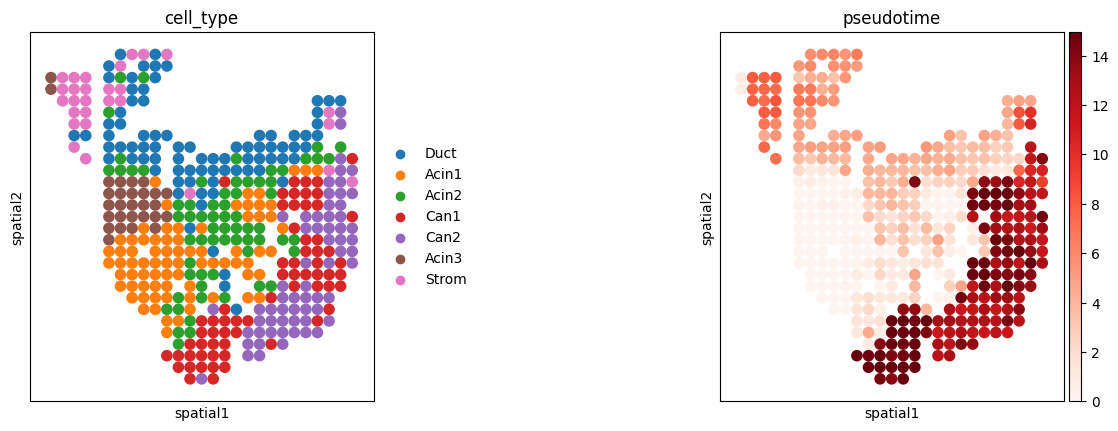

In [4]:
sc.pl.spatial(adata, spot_size=1, color=['cell_type', 'pseudotime'], cmap='Reds', img_key=None)

# L-R database

In [5]:
LRDatabase_D = create_LRDatabase_D(
    adata,
    min_cell_pct=0.01,
    database='CellChat',
    species='human'
)

In [6]:
LRDatabase_D.shape

(79, 89)

In [7]:
CCCProb = SCILD(adata=adata,
                LRDatabase_D=LRDatabase_D,
                neighbor_k=5,
                niter_max=100,
                eps=1e-4,
                verbose=True,
                plot_error=True
                )
CCCProb.preparing()
nl = CCCProb.nl
nr = CCCProb.nr
ns = CCCProb.ns
print('The number of ligand is: ' + str(nl))
print('The number of receptor is: ' + str(nr))
print('The number of spot is: ' + str(ns))

*************Preparing*************
neighbor_k: 5
The number of ligand is: 79
The number of receptor is: 89
The number of spot is: 407



*************Solving*************
The relative error is: 0.05567292633050795
The relative error is: 0.027855492768697223
The relative error is: 0.01967423687472713
The relative error is: 0.015470440752352583
The relative error is: 0.012872426296307787
The relative error is: 0.011085766943309783
The relative error is: 0.009771441236986055
The relative error is: 0.008757982003421018
The relative error is: 0.007949002938361179
The relative error is: 0.007288392543300237

 The final relative error is: 0.007288392543300237
The total iteration step is: 100


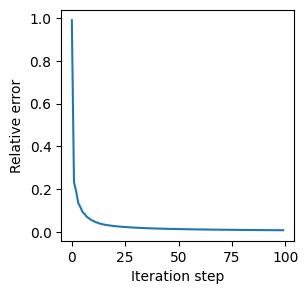

In [8]:
mu0 = np.random.random(nl * ns).reshape(-1, 1)
v0 = np.random.random(nr * ns).reshape(-1, 1)
CCCProb.solving_optimization(mu0, v0)

In [9]:
CCCProb.adata

AnnData object with n_obs × n_vars = 407 × 12233
    obs: 'cell_type', 'x', 'y', 'pseudotime'
    uns: 'cell_type_colors'
    obsm: 'spatial', 'sum-sender-Q', 'sum-sender-P', 'sum-receiver'

# Extract LR CCC

In [10]:
CCCProb.query_all_LR()

In [11]:
CCCProb.tensor_P.shape

(407, 407, 79, 89)

# Visualization

select L-Rs to show (spatial)

In [12]:
CCC_df = CCCProb.compute_TSSR()
CCC_adata = sc.AnnData(CCC_df)
CCC_adata.obsm['spatial'] = adata.obsm['spatial']
CCC_adata

AnnData object with n_obs × n_vars = 407 × 464
    obsm: 'spatial'

In [13]:
LR_df_spatial = compute_spatial_autocorrelation(CCC_adata)
LR_df_spatial.sort_values('moran_I', ascending=False).head()

,moran_I,p_value
PRSS2->F2R (S),0.625772,8.092024e-193
PRSS2->F2RL2 (S),0.599467,3.527733e-177
C3->C3AR1 (S),0.552651,5.380803e-151
PRSS2->F2RL3 (S),0.550782,5.403147e-150
PRSS3->F2RL2 (S),0.500452,2.715456e-124


In [14]:
CCCProb.adata.obs[CCC_df.columns] = CCC_df
CCCProb.adata.obs.head()

,cell_type,x,y,pseudotime,ADM->CALCRL (S),ADM->CALCRL (R),AGT->MAS1 (S),AGT->MAS1 (R),ANGPT2->ITGA5 (S),ANGPT2->ITGA5 (R),...,WNT7B->FZD5 (S),WNT7B->FZD5 (R),WNT7B->FZD6 (S),WNT7B->FZD6 (R),WNT7B->FZD7 (S),WNT7B->FZD7 (R),WNT7B->LRP5 (S),WNT7B->LRP5 (R),WNT7B->LRP6 (S),WNT7B->LRP6 (R)
spots,,,,,,,,,,,,,,,,,,,,,
10x10,Strom,10,10,7.654976,7.131245e-28,1.700853e-08,6.784588e-07,4.598179e-08,9.735681e-26,1.638297e-25,...,3.257486e-49,2.288567e-50,1.884703e-43,2.288675e-50,3.848215e-50,2.288524e-50,1.884709e-43,1.072291e-19,3.894326e-50,1.072309e-19
10x13,Duct,13,10,4.635943,9.673187e-28,6.256036e-20,1.622884e-06,2.217905e-07,3.546331e-26,1.452562e-09,...,5.652274e-50,6.899549e-50,8.505613e-45,6.899926e-50,6.351476e-50,6.899624e-50,5.680613e-43,1.282107e-48,6.414340e-50,1.282109e-48
10x14,Duct,14,10,5.101666,5.382776e-28,1.099464e-19,3.588143e-29,2.355473e-09,3.553766e-26,2.084649e-06,...,4.085063e-50,3.735329e-08,1.660876e-47,3.734564e-08,1.643045e-49,3.735012e-08,5.580781e-43,3.738662e-08,2.711985e-49,3.737750e-08
10x15,Duct,15,10,4.847695,1.006580e-27,3.729695e-18,8.386616e-29,1.615886e-07,3.924654e-26,1.252110e-32,...,4.106953e-50,8.106283e-10,1.865531e-49,8.108621e-10,2.929671e-49,8.119603e-10,1.089983e-42,8.246196e-10,4.643513e-49,8.255941e-10
10x16,Duct,16,10,4.850841,1.802696e-27,1.696951e-08,3.233755e-29,4.535729e-08,3.588631e-26,9.195386e-33,...,4.599511e-50,5.916747e-12,1.824569e-49,5.919129e-12,4.294812e-49,5.924042e-12,1.426280e-42,5.945011e-12,3.604878e-49,5.937514e-12


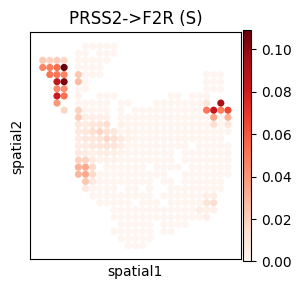

In [15]:
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.spatial(CCCProb.adata, spot_size=1, color="PRSS2->F2R (S)", cmap='Reds', img_key=None)